# 导入相关模组

In [1]:
import yaml
import pcse
#  import sys
import os
import pickle
import copy
import numpy as np
import pandas as pd

from Wofost_opt import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD

In [2]:
data_dir = os.path.join(os.getcwd(), "data")

## 2.1 读取作物参数

In [3]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)


## 2.2 土壤参数

In [4]:
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

## 2.3 站点数据

In [5]:
# NAVAILI       Amount of N available in the pool at initialization of the system [kg/ha]
sited = WOFOST71SiteDataProvider(WAV=18)
# sited = WOFOST72SiteDataProvider(WAV=18)

## 2.4 合并数据

In [6]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.5 读取管理文件

In [7]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

## 2.6 气象数据

In [8]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

# 3 模型运行

In [15]:
# 管理文件数据
agro = my_agro(yaml_agro_2022, 180)

In [16]:
# 参数顺序
parameters_name = ["SLATB001", "SPAN", "EFFTB003", "TMNFTB003", "CVO", "FLTB003", "TDWI", "CVL",
                       "TEFFMX", "EFFTB001", "KDIFTB003"]

In [17]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "opt_ZDN180_result.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
# param_df = param_df[param_df['rmse'] < 0.31]

In [18]:
rows, _ = param_df.shape
modelrerunner = None
modelrerunner = ModelRerunner(parameters, wdp, agro)
for i in range(1):
    p_value = list()
    for each in parameters_name:
        p_value.append(param_df.iloc[i][each])
    result = modelrerunner(p_value, flag=True)
    if modelrerunner.summary[0]['TWSO'] > 9000 and modelrerunner.summary[0]['TWSO'] < 10000:
        print("%i-%.3f" % (i, modelrerunner.summary[0]['TWSO']))
# print(result[0])
print(modelrerunner.summary[0])

{'DVS': 2.0, 'LAIMAX': 4.645377474084804, 'TAGP': 20540.92702098818, 'TWSO': 8411.597598496699, 'TWLV': 3954.184029975637, 'TWST': 8175.145392515844, 'TWRT': 2199.152787511921, 'CTRAT': 24.61643849449689, 'RD': 100.0, 'DOS': datetime.date(2022, 6, 11), 'DOE': datetime.date(2022, 6, 19), 'DOA': datetime.date(2022, 8, 18), 'DOM': datetime.date(2022, 9, 27), 'DOH': None, 'DOV': None, 'CEVST': 7.427626652395314}


In [19]:
res_2021 = result[0]

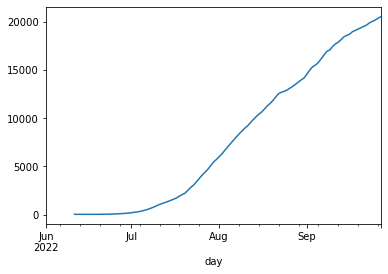

In [21]:
res_2021.TAGP.plot()